# Анализ цены биткоина

Краткое описание работы

В данном ноутбуке планируется проанализировать цену биткоина, для этого мы будем делать следующие шаги:

1)Соберем, обработаем и посмотрим на данные, также немного их подкоректируем и сделаем на их основе новые фичи

- MVRV Z-Score - для биткоина в отличие от классических активов, можно проследить транзакции, куда, когда и в каком количестве перемещались монеты между различными кошельками, эти транзакции можно анализировать. Однако сеть блокчейна включает 300 Гб данных и анализировать транзакции в домашних условиях не представляется возможным, поэтому можно воспользоваться индикаторами которые уже рассчитали люди с большими вычислительными мощностями. Один из таких индикаторов mvrv z-score. Можно посчитать два вида капитализации, один посредством умножения текущей цены на кол-во монет, а другой посредством умножения цены которая была на момент последней транзакции с конкретным биткоином (или его частью), если посчитать их разность получим своего рода общую потенциальную прибыль/убыток всех владельцев btc, её также можно поделить на дисперсию, тогда полученный индикатор можно интерпретировать так: есть те кто на ежедневной основе продает/покупает монеты, для этих монет индикатор будет околонулевой, а есть те люди кто держат свои монеты достаточно долго, разность между капитализацией их монет может быть отлична от нуля, когда они решат что монеты пора продавать эта разность снова сократится и наоборот вырастет если большая часть людей будет держать монеты в своих кошельках. Стоит сделать ремарку о том что сам по себе индекс является скорее следствием (во всяком случае в нашем анализе мы смотрим на дневные графики, возможно в HFT- high frequency trading это не так), мы будем использовать этот индекс исключительно для того чтобы понимать в какой фазе находится рынок биткоинов и какого соотношение инвесторов к трейдерам, и возможно для каждой стадии делать свою модель для прогноза, либо прогнозировать это значение - это может быть проще чем прогнозировать цену биткоина, но не менее информативно.


- Также биткоин тесно связан с мировой экономикой, поэтому для анализа его цены будем также использовать фьючерсы на трежерис, золото и некоторые другие активы, проанализируем их влияние, посмотрим на графики и построим модели для разных стадий рынка.

2)Проанализируем насколько связаны движения цен классических активов и цены btc, часто инвесторам важно не столько получать сверхприбыль (что конечно тоже замечательно, но не всегда легко достижимо), сколько грамотно управлять рисками и понимать, что будет происходить при той или иной ситуации.

3)После этого по результатам предыдущего шага построим модель прогнозирующую цену на btc, посмотрим её результаты, протестируем на тестовых данных и посмотрим насколько значимыми получились результаты, какие признаки оказали наибольшее влияние, попытаемся интерпретировать полученные как в этом, так и в предыдущем пункте результаты



Ссылки на источники данных

1)https://charts.coinmetrics.io/ - пожалуй единственный сайт на котором можно скачать данные за бесплатно

2)https://www.minneapolisfed.org/banking/current-and-historical-market--based-probabilities - Market-Based Probabilities для обычных активов не для крипты (в основном это фьючерсы на различные активы)

Возможно по ходу обучения модели / проверки гипотез будет выявляться необходимость в загрузке других данных, тогда сюда будут добавлены ещё данные

Ещё некоторые полезные ссылки (не используются напрямую, но могут быть полезны для понимания)

1)https://www.youtube.com/watch?v=_160oMzblY8 - лучшее объяснение того как работает блокчей всего за 17 минут.
https://www.youtube.com/watch?v=xIDL_akeras - его вторая часть на 8 мин.

2)https://www.lookintobitcoin.com/charts/mvrv-zscore/ - тут можно прочитать про mvrv z-score

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.stattools import medcouple

In [5]:
def display_data(frame: pd.DataFrame, title: str) -> None:
  """
    Отображает данные и их распределение на графике
  """
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))
  frame.plot(ax=axes[0], title=title)
  frame.hist(ax=axes[1])

  pass


def load_coinmetrics(path: str) -> pd.DataFrame:
  """
    Для загрузки и отображения данных, о цене биткоина и его mvrv
  """

  df = pd.read_excel(path)
  df['Time'] = df['Time'].astype('datetime64[ns]')
  df.set_index('Time', inplace=True)

  display_data(frame=df, title=path.split('/')[2][:-5])

  return df

def medcouple_interval(df: pd.DataFrame) -> tuple([float, float, float]):
  """
    Возвращает доверительный интервал для детекции выбросов,
    решил взять medcouple поскольку этот метод более-менее робастный,
    что актуально в данном случае
  """
  MC = medcouple(df.values)
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3-Q1

  if MC>=0:
    min_value = Q1-1.5*np.exp(-4*MC)*IQR
    max_value = Q3+1.5*np.exp(3*MC)*IQR
  else:
    min_value = Q1-1.5*np.exp(-3*MC)*IQR
    max_value = Q3+1.5*np.exp(4*MC)*IQR

  return MC, min_value, max_value


def scale(df: pd.DataFrame) -> pd.DataFrame:
  """
    Отображает данные в промежуток 0-100 и 
    чистит от выбросов
  """
  df = df.copy()
  # Удалим выбросы
  MC, min_value, max_value = medcouple_interval(df)
  min_value, max_value = min_value, max_value

  df[[(df<min_value).values]] = min_value
  df[[(df>max_value).values]] = max_value

  # Впишем данные в промежуток 0-100
  scaler = MinMaxScaler()
  scaler.fit(df.values)
  df = pd.DataFrame(scaler.transform(df), index=df.index)*100

  return df


def fourier_clean(df: pd.DataFrame) -> pd.DataFrame:
  """
    Удаляет шум с помощью ряда Фурье,
 
    P.S. в текущей версии не используется, 
    была нужна в процессе построения новых фичей и проведения экспериметов,
    возможно ещё потребуется в будущем
  """
  # Очистим от шума
  n = 3 # чем больше n тем больше удаляется шумов
  fourier_transform = np.fft.fft(df, axis=0)
  threshold = np.max(np.abs(fourier_transform)) / (np.mean(np.abs(fourier_transform))/n)
  indices = np.where(np.abs(fourier_transform) < threshold)
  fourier_transform[indices] = 0
  filtered_time_series = np.fft.ifft(fourier_transform, axis=0)

  return filtered_time_series

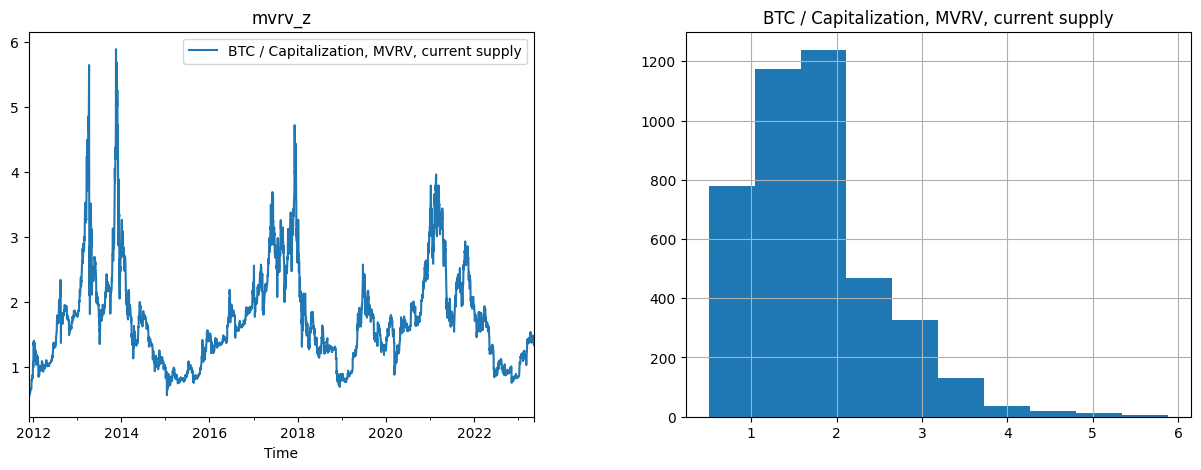

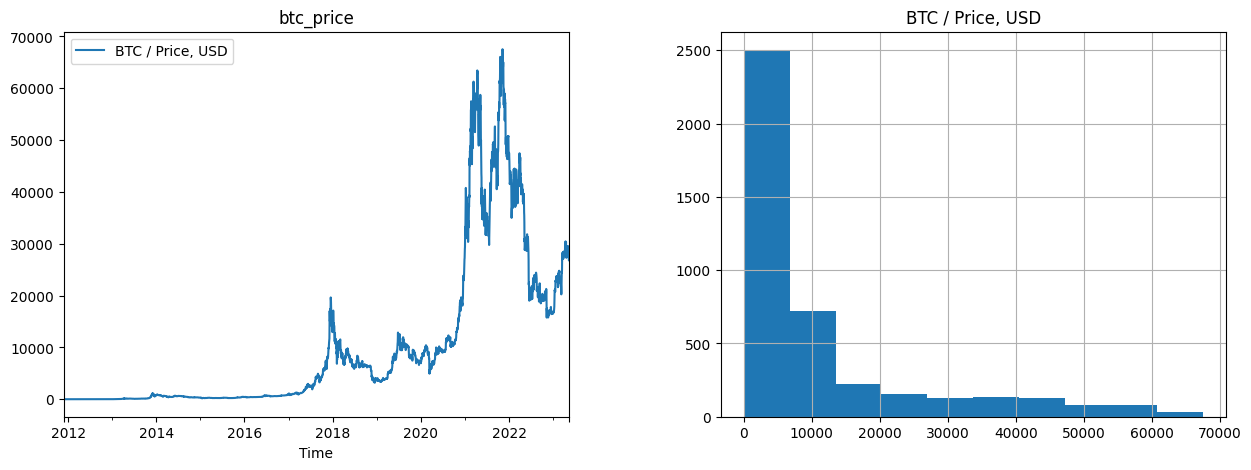

In [6]:
df_mvrvz = load_coinmetrics('/content/mvrv_z.xlsx')
df_btc = load_coinmetrics('/content/btc_price.xlsx')

Как видно индекс со временем затухает, хочется чтобы индекс принимал значения в заданном промежутке, условно говоря от 0 до 100, я бы изначально рассчитывал его немного подругому, но поскольку как я уже говорил в домашних условиях это сделать нельзя, будем корректировать то что имеем. Изначально была попытка взять логарифм от разности, но это ни к чему хорошему не привело, чтобы исправить затухание со временем разделим на дисперсию с окном, также немного подкорректируем распределение взяв логарифм, получится то что и планировалось, 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


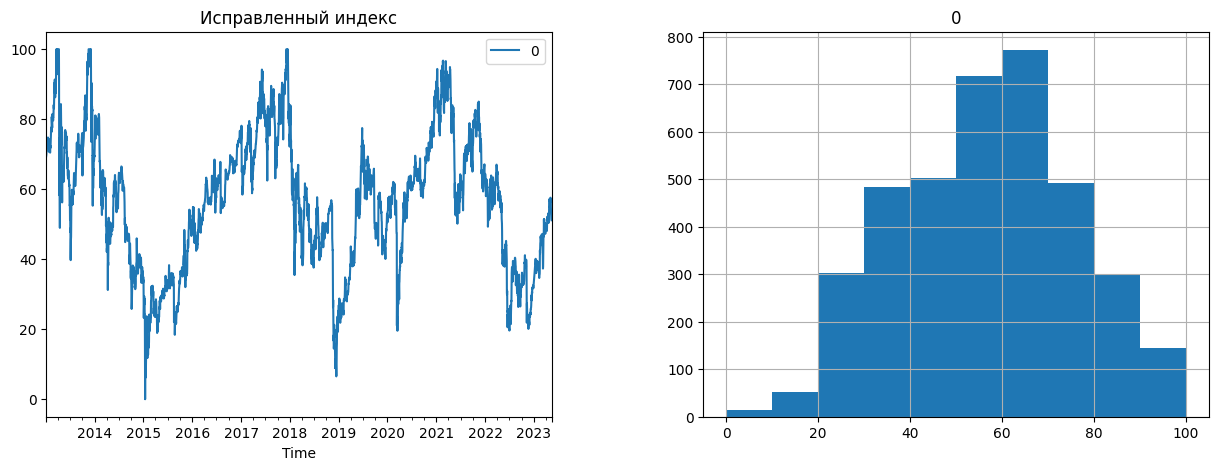

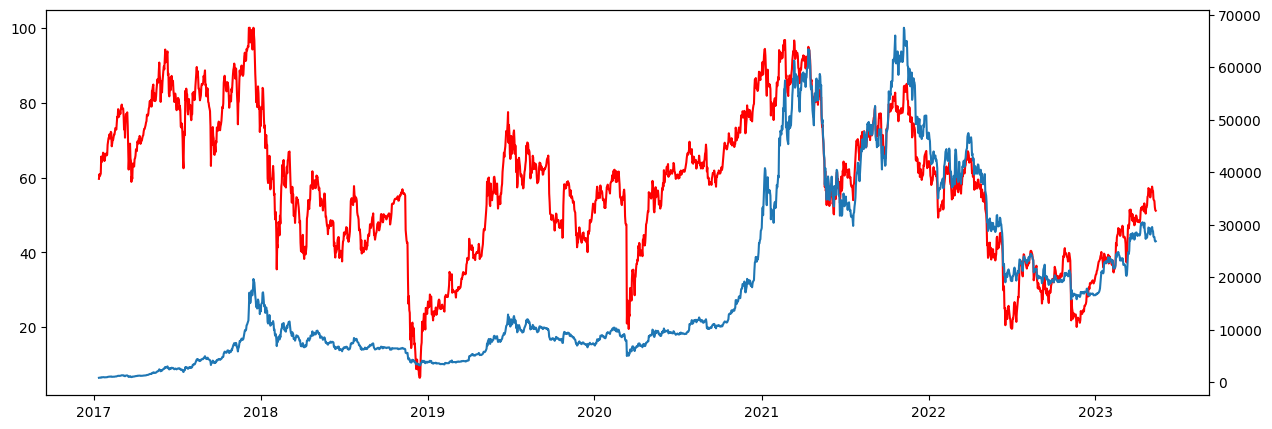

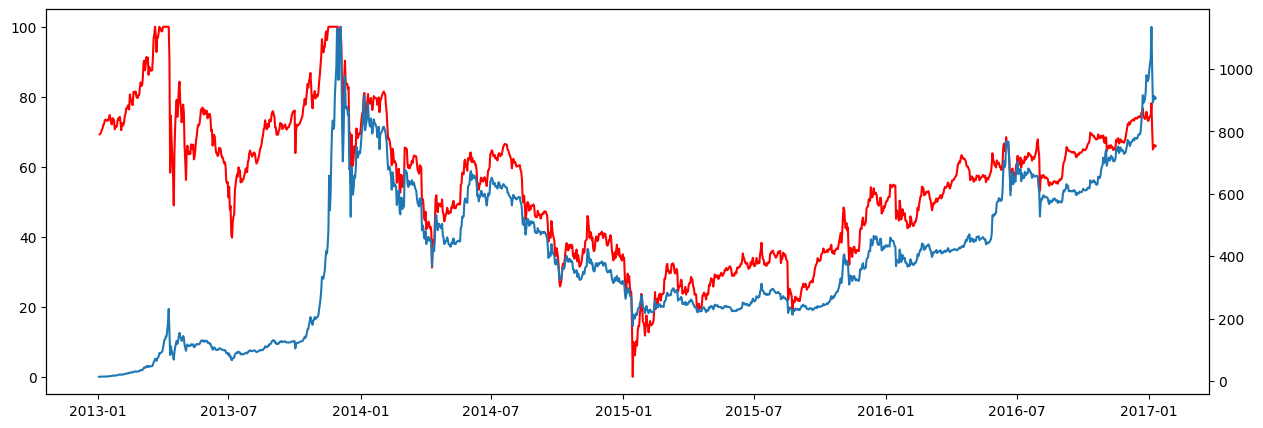

In [7]:
ind = np.log(df_mvrvz[df_mvrvz.index > '2013-01-02']/np.power(df_mvrvz.rolling(40).std()[df_mvrvz.index > '2013-01-02'], 1/8))
ind = scale(ind)
filtered_time_series = ind #.ewm(span=10 , adjust=False).mean()

display_data(ind, 'Исправленный индекс')

fig, ax = plt.subplots()
fig.set_size_inches((15, 5))
ax1 = ax.twinx()
ax.plot(ind[ind.index>'2017-01-11'].index, filtered_time_series[ind.index>'2017-01-11'], c='r')
ax1.plot(df_mvrvz[df_btc.index>'2017-01-11'].index, df_btc[df_mvrvz.index>'2017-01-11'].values)

fig, ax = plt.subplots()
fig.set_size_inches((15, 5))
ax1 = ax.twinx()
ax.plot(ind.index[ind.index<'2017-01-11'], filtered_time_series[ind.index<'2017-01-11'], c='r')
ax1.plot(df_mvrvz[(df_btc.index>'2013-01-01') & (df_btc.index<'2017-01-11')].index, df_btc[(df_btc.index>'2013-01-01') & (df_btc.index<'2017-01-11')].values)


In [8]:
futures_info = pd.read_csv('/content/mpd_stats.csv', skiprows=3)
futures_info['idt'] = futures_info['idt'].astype('datetime64[ns]')
assets_dict = {} 

for asset in futures_info['market'].unique():
  assets_dict[asset] = futures_info[futures_info['market']==asset].set_index('idt')

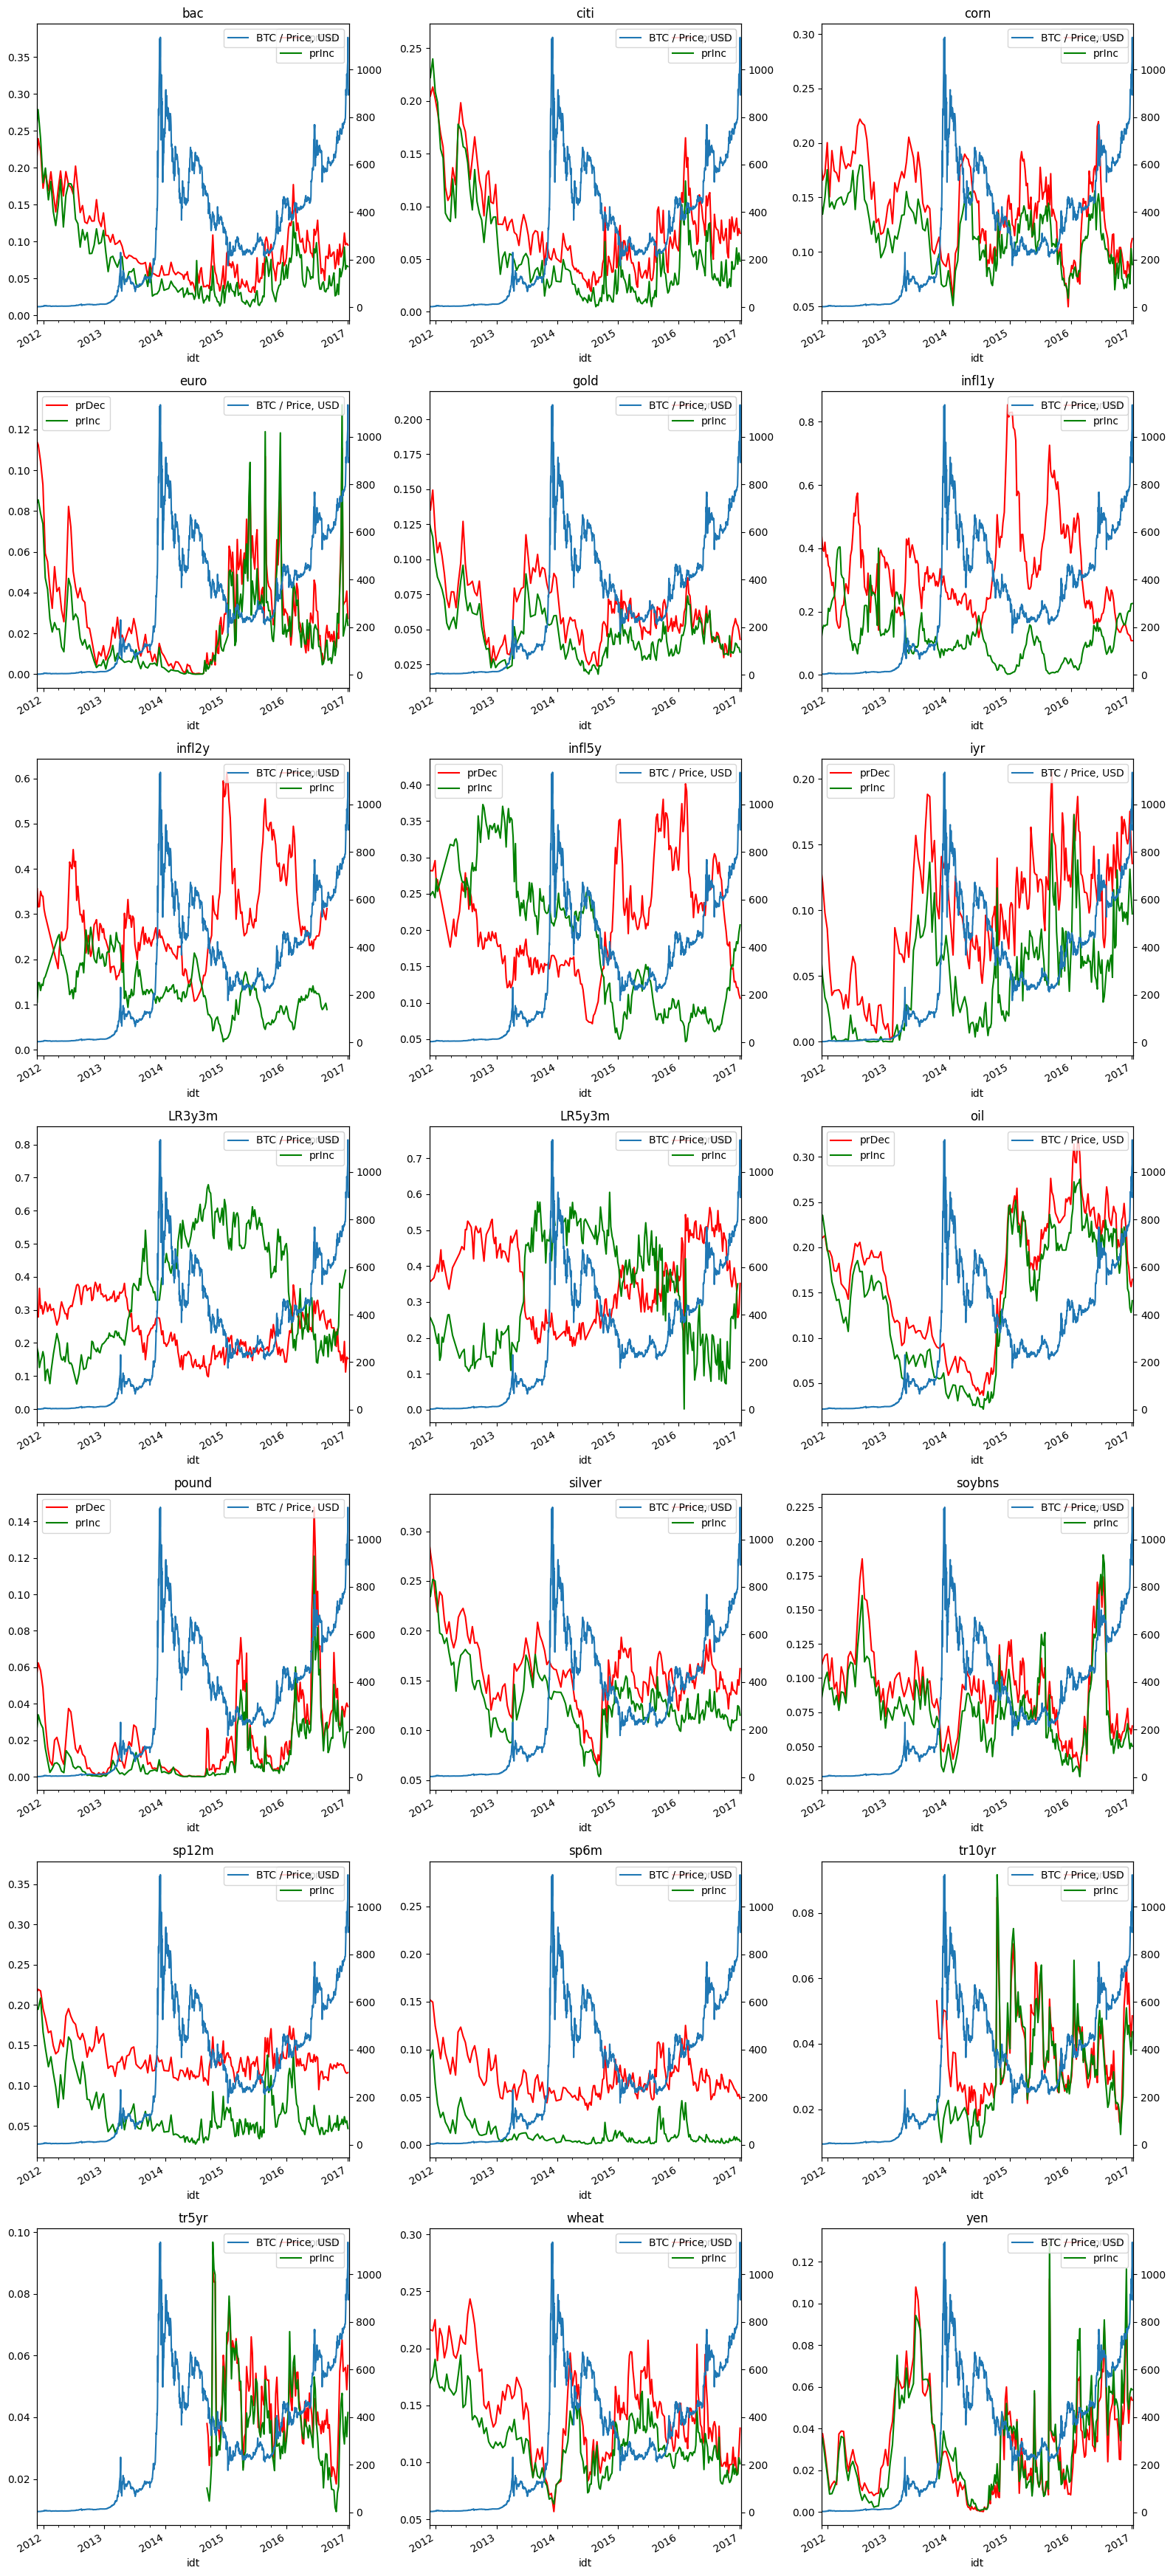

In [9]:
fig, axs = plt.subplots(7, 3, figsize=(16, 35))


for i, key in enumerate(assets_dict.keys()):

    df = assets_dict[key][['prInc', 'prDec']]


    df[['prDec']][df.index<'2017-01-11'].plot(ax=axs[i//3][i%3], title=key, c='r')
    df[['prInc']][df.index<'2017-01-11'].plot(ax=axs[i//3][i%3], title=key, c='g')
    df_btc[df_btc.index<'2017-01-11'].plot(ax=axs[i//3][i%3].twinx())

fig.tight_layout()

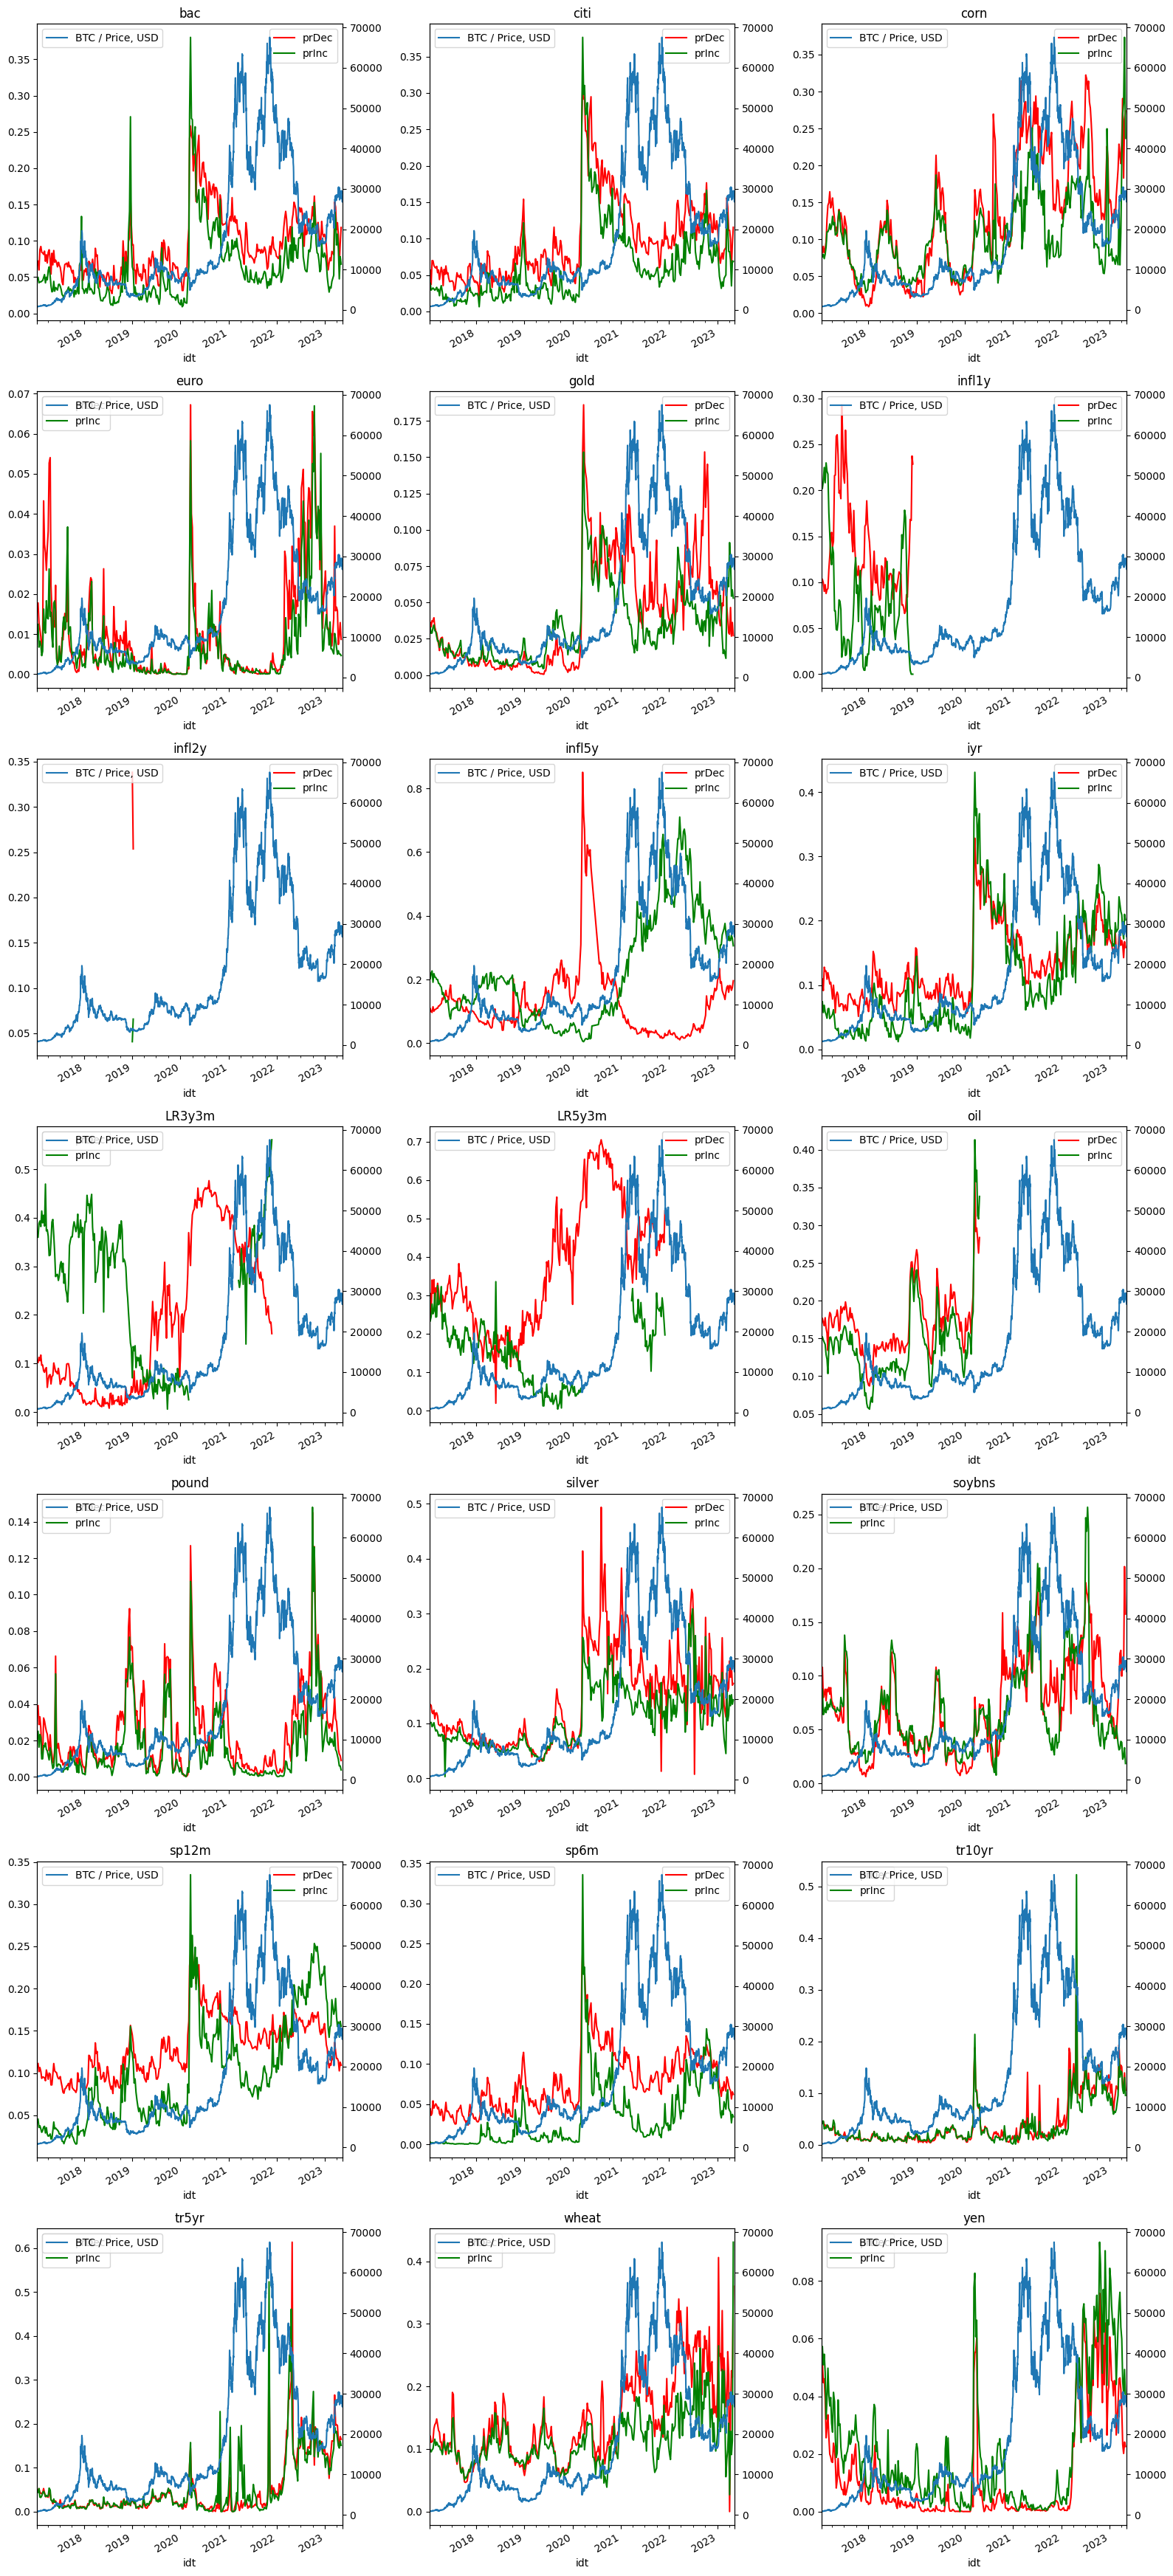

In [10]:
fig, axs = plt.subplots(7, 3, figsize=(16, 35))


for i, key in enumerate(assets_dict.keys()):

    df = assets_dict[key][['prInc', 'prDec']]


    df[['prDec']][df.index>'2017-01-11'].plot(ax=axs[i//3][i%3], title=key, c='r')
    df[['prInc']][df.index>'2017-01-11'].plot(ax=axs[i//3][i%3], title=key, c='g')
    df_btc[df_btc.index>'2017-01-11'].plot(ax=axs[i//3][i%3].twinx())

fig.tight_layout()

Если внимательно просмотреть графики выше можно выдвинуть предположение, что фьючерсы трежерис(tr10yr и tr5yr) и s&p (sp6m) имеют обратную зависимость с ценой биткоина, также и падение инфляции (infl5y), а вероятность роста инфляции с некоторым запозданием следует за биткоином, также рост процентной ставки имеет положительную зависимость (LR3y3m) это libor он сейчас используется все меньше и в дальнейшем следует подгрузить SOFR. Тем не менее все эти гипотезы ещё предстоит проверить, а также обучить и проинтерпретировать модель